# Context

Recent studies have shown that breast cancer continues to be the leading cause of death among women over the world. If detected at an early stage, it can be cured in 9 out of 10 cases.

Automated detection and segmentation of cells from images are the crucial and fundamental steps for the measurement of cellular morphology that is crucial for brest cancer diagnosis and prognosis.


In this notebook, you will learn how to train a segmentation as UNet with **monai** - a framwork based Pytorch Stadard for healthcare imaging.

## Monai

MONAI is a pytorch based open source AI framework launched by NVIDIA and King’s College London.
It is integrated with training and modelling workflows in a native PyTorch Standard. t several places.


Install monai

In [3]:
# !pip install monai
# !pip install numpy==1.26.4

Check the installation by running the following cell

In [ ]:
import monai
monai.config.print_config()

#  Dataset

To train a model, we need to prepare some ingredients:

1. Dataset
2. Model
3. Loss function
4. Optimizer

# I. Create Dataset

There are two ways to create your dataset:
- with pytorch Dataset
- with monai.data.Dataset.

In this exercise, we will create our dataset using torch.utils.data.Dataset.

## 1. List all files in folder

Download the dataset from https://zenodo.org/record/1175282#.YMn_Qy-FDox

Notice that there are two kind of folder : original cell picture folder and mask folders. Using your file explorer or some code, display one image and the corresponding image

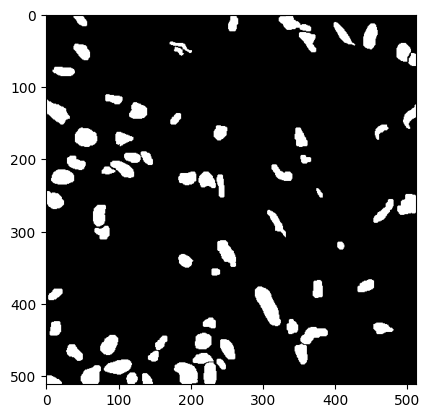

In [6]:
# display image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

image_path = 'TNBC_NucleiSegmentation/GT_01/01_1.png'
im = Image.open(image_path)
plt.imshow(im, cmap='gray')

## 2. Define a transform
When you load your data, you need to define some transformation. For example, we want to convert image to the format [num_channels, spatial_dim_1, spatial_dim_2] because monai/pytorch use this format. We'll also need to convert the images to PyTorch tensors with transforms.ToTensor()

The following code lets you load image and the labels and define several steps to transform the data.


In [128]:
import torch

from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ToTensor, NormalizeIntensity
from monai.transforms import ScaleIntensity

from monai.data import PILReader

image_trans = Compose(
    [
        LoadImage(image_only=True, reader=PILReader(converter=lambda image: image.convert("RGB"))),
        EnsureChannelFirst(),
        NormalizeIntensity(),
        ToTensor(),
    ])


label_trans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        ToTensor(),
    ])


## 3. Create dataset

The following class CellDataset allows us to create our dataset from "image_files" and "label_files" where:
- "image_files" is a list of image names
- "label_files" is the list of segmentation names respectively.

"im_trans" and "label_trans" are respectively the transforms for the images and their labels.




In [129]:
import torch

class CellDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, label_files, im_trans, label_trans):
        self.image_files = image_files
        self.label_files = label_files
        self.im_trans = im_trans
        self.label_trans = label_trans

    def __len__(self):
        return(len(self.image_files))

    def __getitem__(self, index):
        return self.im_trans(self.image_files[index]), self.label_trans(self.label_files[index])


By using this class, create your training dataset et your test dataset. Remember to check if your dataset is loaded correctly.

In [130]:
from glob import glob

image_files_train = [file for i in range(1, 8) for file in glob(f'TNBC_NucleiSegmentation/Slide_{i:02d}/*.png')]
label_files_train = [file for i in range(1, 8) for file in glob(f'TNBC_NucleiSegmentation/GT_{i:02d}/*.png')]

image_files_test = [file for i in range(8, 12) for file in glob(f'TNBC_NucleiSegmentation/Slide_{i:02d}/*.png')]
label_files_test = [file for i in range(8, 12) for file in glob(f'TNBC_NucleiSegmentation/GT_{i:02d}/*.png')]

train_dataset = CellDataset(image_files=image_files_train, label_files=label_files_train, im_trans=image_trans, label_trans=label_trans)
image_files_test = CellDataset(image_files=image_files_test, label_files=label_files_test, im_trans=image_trans, label_trans=label_trans)

## 4. DataLoader

With the your dataset loaded, you have to pass it to a DataLoader. The torch.utils.data.DataLoader takes a dataset and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.


The following code let you create a data loader for the train dataset, do the same to create a test_loader on the test_dataset. Name it **test_load**


In [140]:
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(image_files_test, batch_size=batch_size, shuffle=False)

## 5. Now, time to check your dataloader.

Execute the code following to check if your dataloader works correctly

In [141]:
import monai
im, seg = monai.utils.misc.first(train_loader)
im.shape

torch.Size([1, 3, 512, 512])

# II. Build your segmentation model with monai

Monai already has a UNet model architecture : https://docs.monai.io/en/stable/networks.html#unet

By using the monai.networks.nets module, build a UNet model for segmentation task in 2D. You'll have to choose the following parameters for the model:

1. dimensions (number of spatial dimensions)
2. in_channels (number of input channel)
3. out_channels (number of output channel)
4. channels
5. strides


In [196]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from monai.networks.nets import UNet

# Define the UNet model
model = UNet(
    spatial_dims=2,         # 2D segmentation
    in_channels=3,         # Number of input channels (e.g., grayscale image)
    out_channels=1,        # Number of output channels (e.g., binary segmentation)
    channels=(4,16,32),  # Number of channels in each layer
    strides=(2, 2,),   # Strides for each layer
    num_res_units=2,              # Adding residual units for deeper learning
    norm='batch',                 # Use batch normalization
    dropout=0.2  
)

# III. Define your loss function and optimizer

For a segmentation prob, we usually use DiceLoss.
Using monai.losses.DiceLoss, define your loss function and store it in the variable named **loss_function**. The option sigmoid = True should be used.




In [197]:
from monai.losses import DiceLoss

# Define the loss function
loss_function = DiceLoss(sigmoid=True)

# Print the loss function to verify
print(loss_function)

DiceLoss()


With torch.optim, define an optimizer for your model. Use the Adam optimiser

In [198]:
import torch.optim as optim

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Print the optimizer to verify
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


# IV. Trainning the model

This time, we have all ingredients to train a segmentation model: a model, an optimizer, train_loader and a loss function.  

Monai use a standard PyTorch program style for training a deep learning model.


The general process with Monai/Pytorch just for one learning step  as follows:

1. Load input and label of each batch.

2. Zero accumulated gradients with optimizer.zero_grad()

3. Compute the output from the model

4. Calculate the loss

5. Perform backprop with loss.backward()

6. Update the optimizer with optimizer.step()


Complete the following code so that it do the training


In [207]:
from torch.optim.lr_scheduler import LambdaLR
epoch_loss_values = list()
# Define the lambda function for learning rate warm-up
def lr_lambda(epoch):
    if epoch < 5:
        return (float(epoch) / 5)
    else:
        return 1.0

# Create the learning rate scheduler
scheduler = LambdaLR(optimizer, lr_lambda)

for epoch in range(10):

    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()

        #compute the model predictions using the model variable and inputs
        predictions = model(inputs)

        # compute the loss using the loss function, the predictions and labels
        loss = loss_function(predictions, labels)

        # use the backward method of the loss variable to  compute the gradient of the loss used to find the minimum of the loss function
        loss.backward()

        # call the step method of the optimizer
        optimizer.step()

        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        if step%11 == 0 :
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
    
    scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")


11/33, train_loss: 0.3432
22/33, train_loss: 0.2699
33/33, train_loss: 0.1787
epoch 1 average loss: 0.2106
11/33, train_loss: 0.2182
22/33, train_loss: 0.2047
33/33, train_loss: 0.1785
epoch 2 average loss: 0.2082
11/33, train_loss: 0.2360
22/33, train_loss: 0.3404
33/33, train_loss: 0.2497
epoch 3 average loss: 0.2071
11/33, train_loss: 0.2119
22/33, train_loss: 0.2140
33/33, train_loss: 0.2144
epoch 4 average loss: 0.2109
11/33, train_loss: 0.1879
22/33, train_loss: 0.1614
33/33, train_loss: 0.2751
epoch 5 average loss: 0.2117
11/33, train_loss: 0.2542
22/33, train_loss: 0.2057
33/33, train_loss: 0.2302
epoch 6 average loss: 0.2159
11/33, train_loss: 0.1857
22/33, train_loss: 0.2015
33/33, train_loss: 0.2618
epoch 7 average loss: 0.2085
11/33, train_loss: 0.2078
22/33, train_loss: 0.2255
33/33, train_loss: 0.1598
epoch 8 average loss: 0.2131
11/33, train_loss: 0.2298
22/33, train_loss: 0.1766
33/33, train_loss: 0.3283
epoch 9 average loss: 0.2177
11/33, train_loss: 0.3428
22/33, trai

Display the prediction of your model on several image

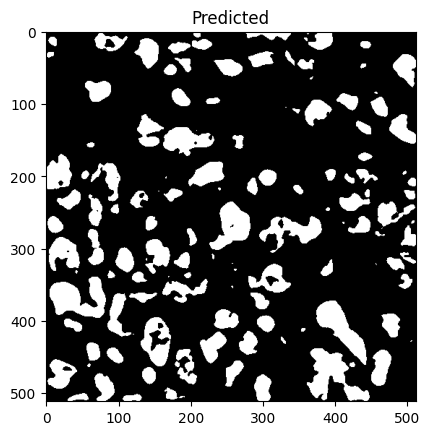

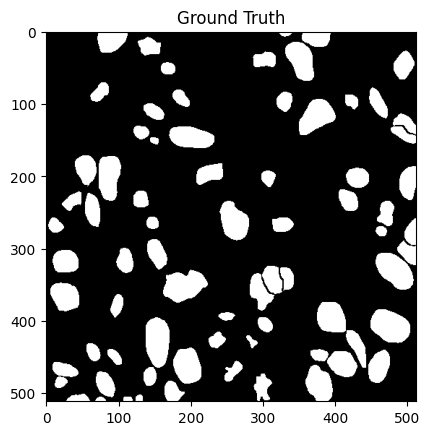

test_loss: 0.3753


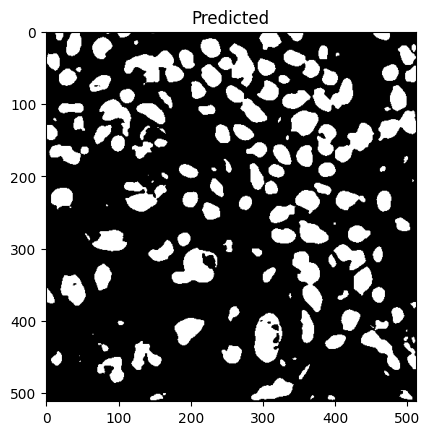

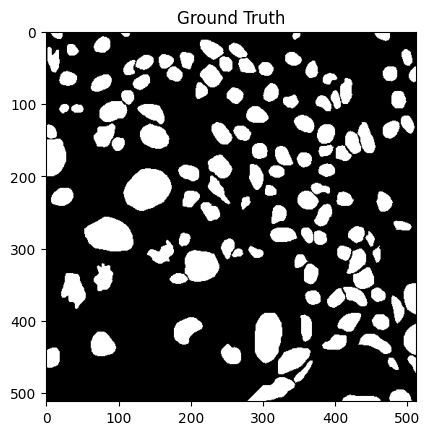

test_loss: 0.2813


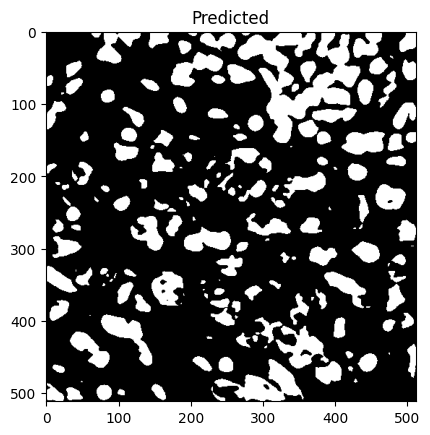

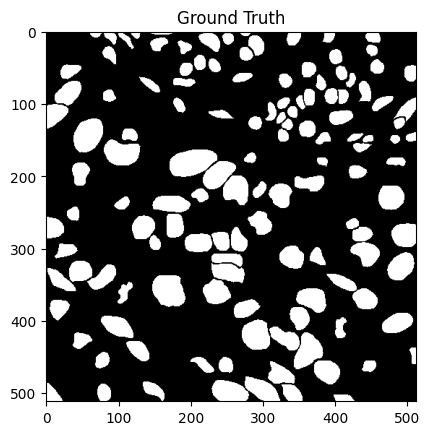

test_loss: 0.3814


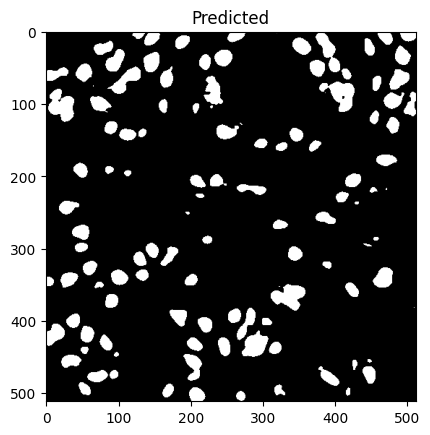

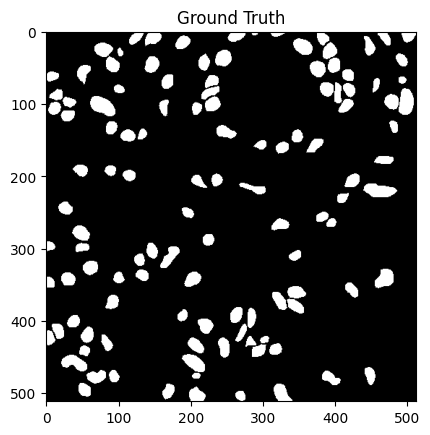

test_loss: 0.2210


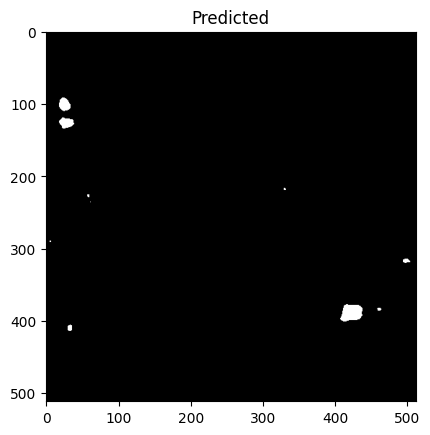

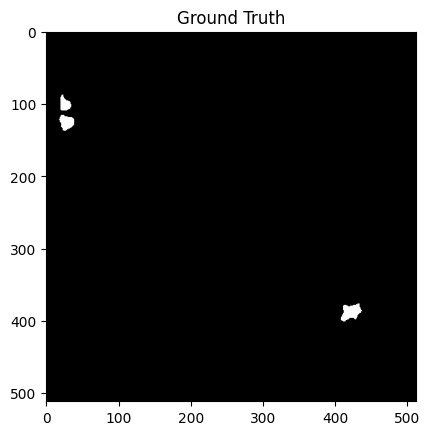

test_loss: 0.2113


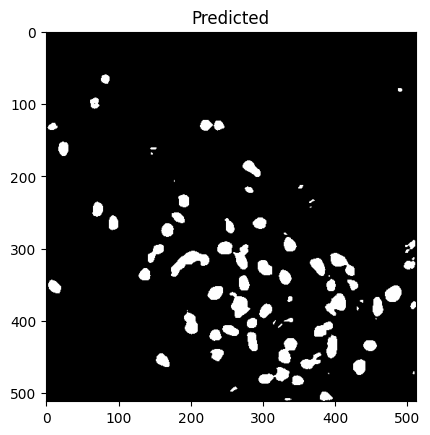

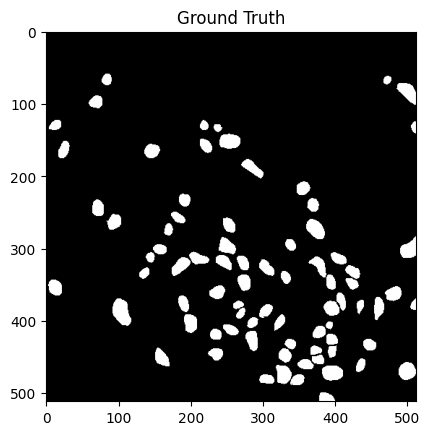

test_loss: 0.3348


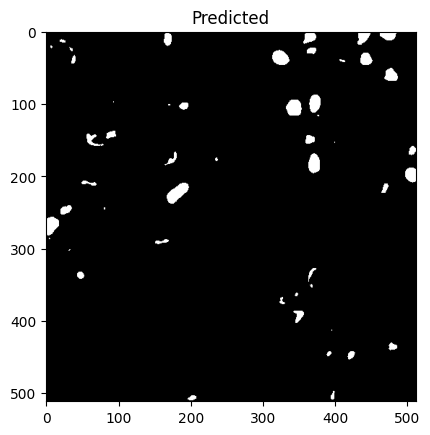

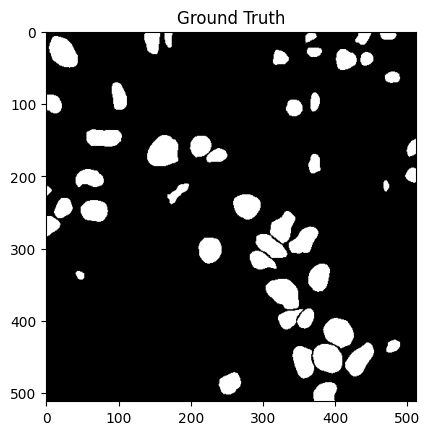

test_loss: 0.7152


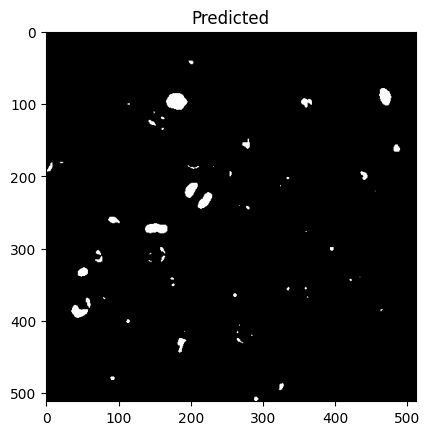

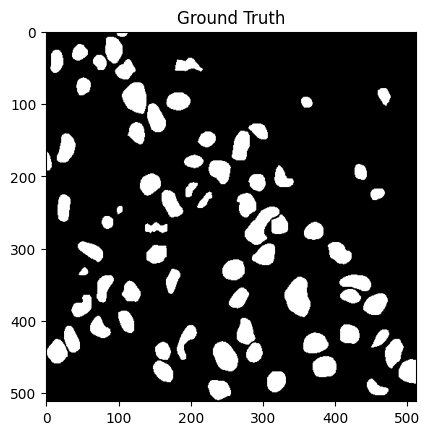

test_loss: 0.8618


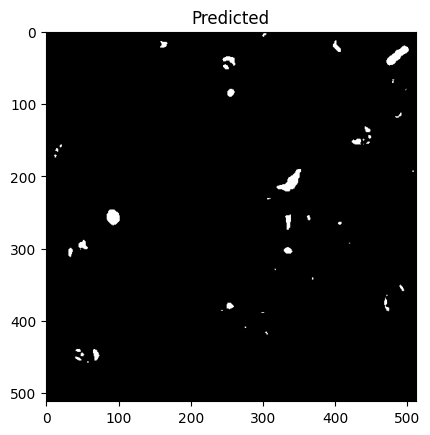

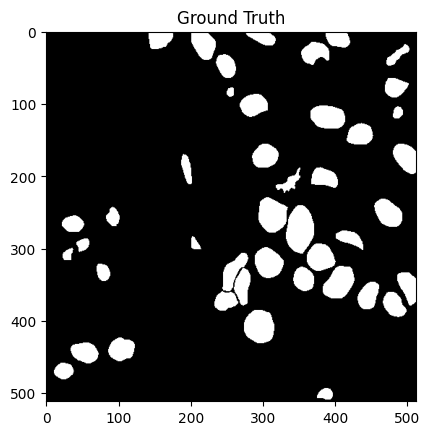

test_loss: 0.8739


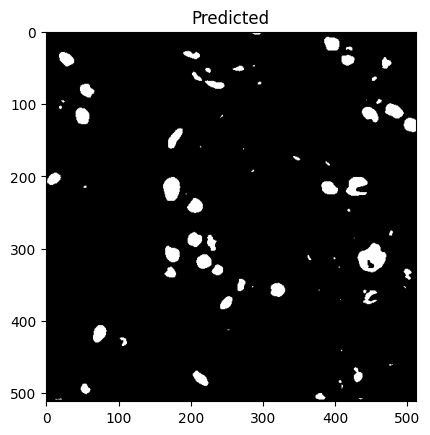

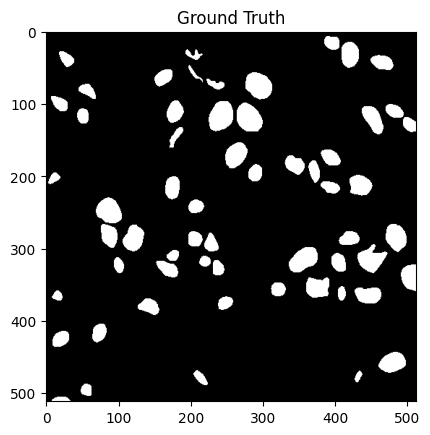

test_loss: 0.5527


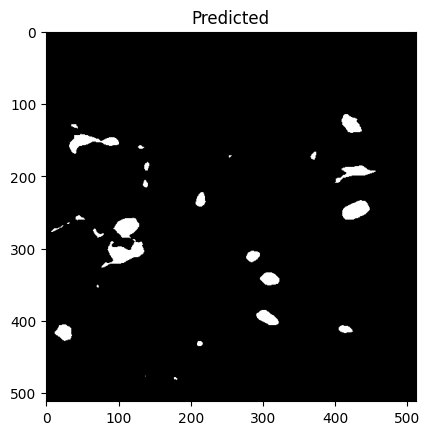

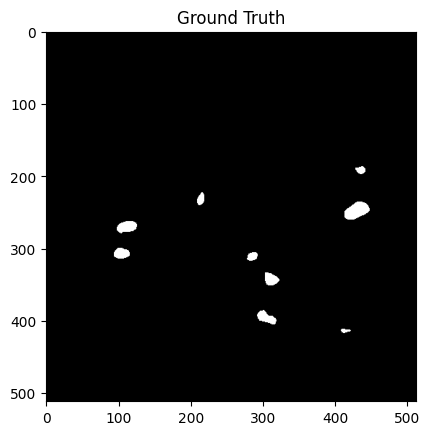

test_loss: 0.4919


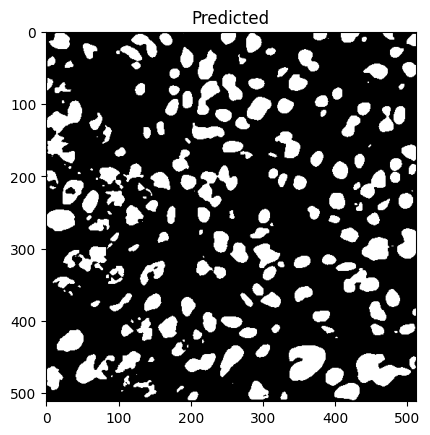

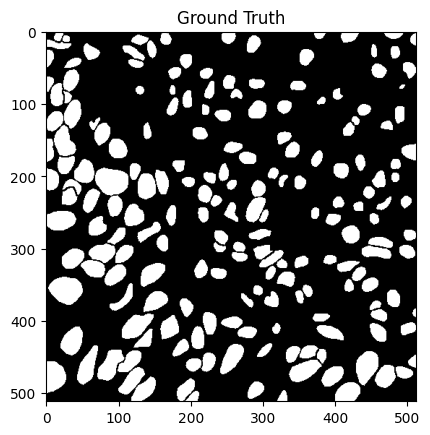

test_loss: 0.2724


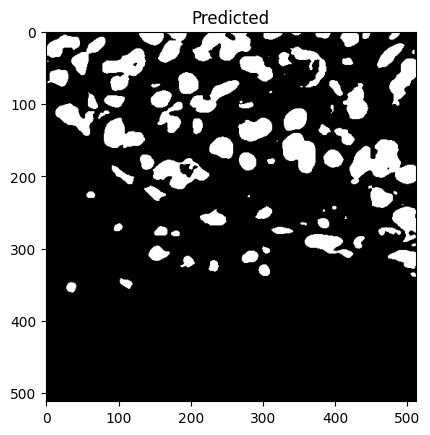

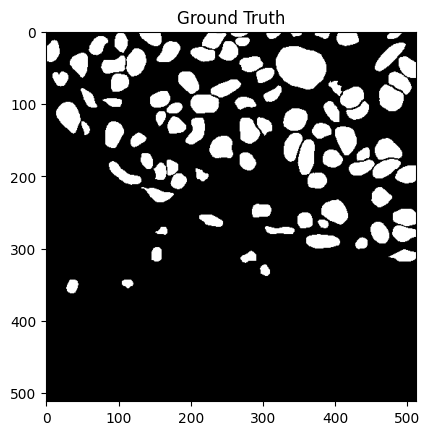

test_loss: 0.2458


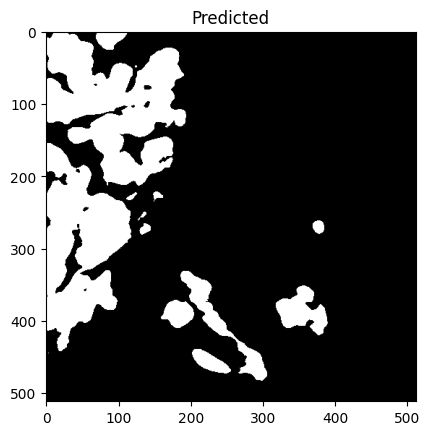

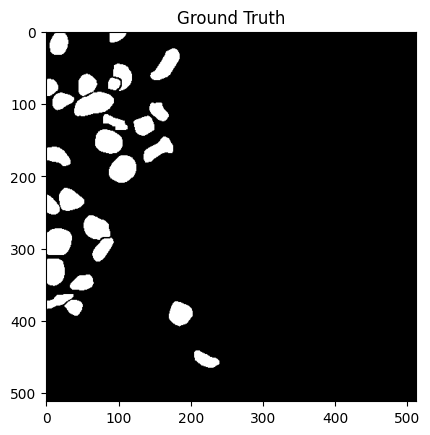

test_loss: 0.4904


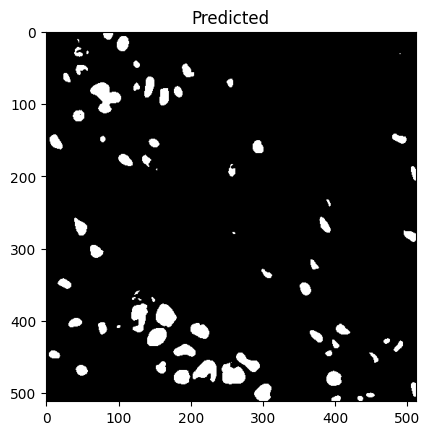

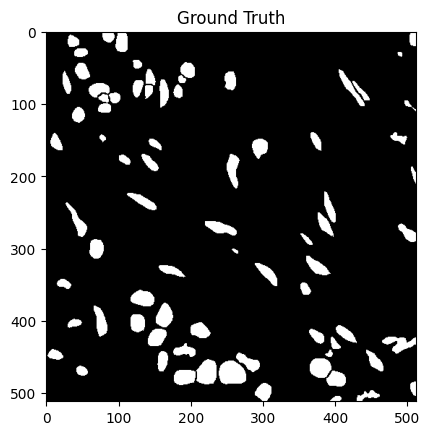

test_loss: 0.3419


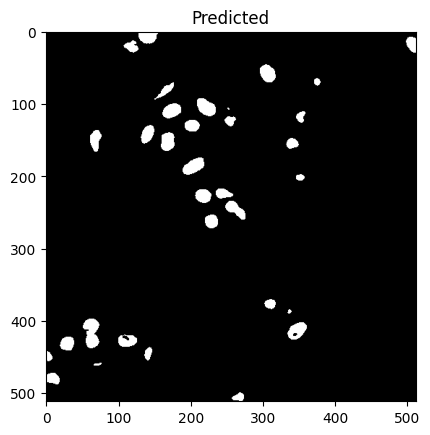

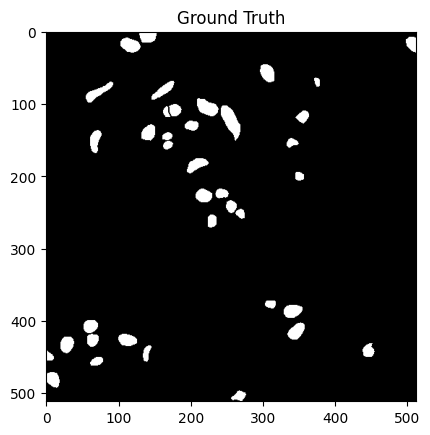

test_loss: 0.2286


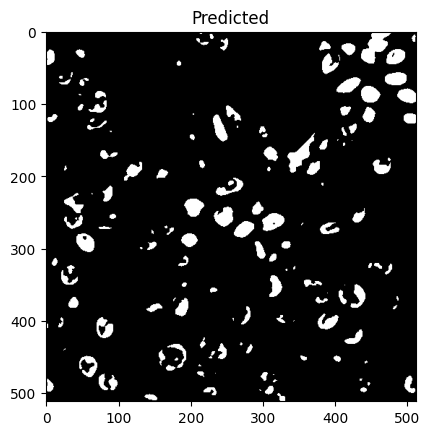

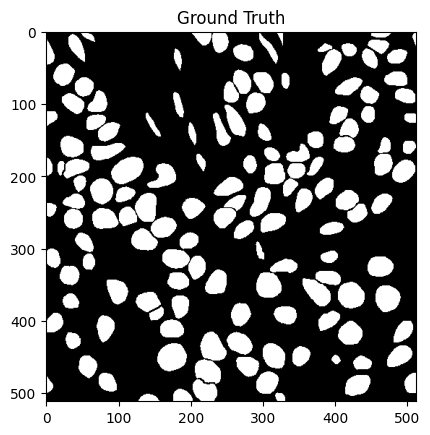

test_loss: 0.5953


In [208]:
model.eval()
for batch_data in test_loader:
    inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
    with torch.no_grad():
        predictions = model(inputs)
        plt.imshow(np.where(predictions[0][0].cpu().detach().numpy()>0, 1, 0), cmap='gray', )
        plt.title("Predicted")
        plt.show()
        plt.imshow(labels[0][0].cpu().detach().numpy(), cmap='gray')
        plt.title("Ground Truth")
        plt.show()
        loss = loss_function(predictions, labels)
        print(f"test_loss: {loss.item():.4f}")

Train another architecture (either another Unet architecture or find another segmentation model in the available models of Monai). Compare the results with the first model